# Low Pass Filter on CSV, in Java - with Graphics

Some imports first

In [1]:
%maven org.knowm.xchart:xchart:3.5.4
import org.knowm.xchart.*;
import java.util.stream.DoubleStream;
import java.util.stream.Collectors;

In [2]:
System.out.println(String.format("Running from folder %s", System.getProperty("user.dir")));

Running from folder /Users/olivierlediouris/repos/oliv-ai/JupyterNotebooks/lowpass


Define the file to read, this one is a Comma-Separated-Values (CSV) file.

In [3]:
final String DATA_FILE = "./max.gust.csv";

Define a list to hold the `gusts` values we will read from the data file

In [4]:
final List<Double> gusts = new ArrayList<>();
final BufferedReader br = new BufferedReader(new FileReader(DATA_FILE));

Read loop. We read the data, and turn the 3rd value into a `double`, stored in the list.

First 10 lines are displayed, to get a sample of the data.

In [5]:
import java.util.concurrent.atomic.AtomicInteger;

private final static int[] COLUMN_LENGTHS = new int[] { 19, 4, 5, 5, 4, 7, 5, 6, 5 };

private void displayLine(String line) {
  String[] array = line.split(",");
  StringBuffer fmtLine = new StringBuffer();
  fmtLine.append("|");
  final AtomicInteger idx = new AtomicInteger(0);
  Arrays.asList(array).stream().forEach(cell -> {
    String fmtCell = String.format(" %" + String.valueOf(COLUMN_LENGTHS[idx.get()]) + "s |", cell); 
    fmtLine.append(fmtCell);  
    idx.set(idx.get() + 1);
  });
  System.out.println(fmtLine.toString());
}

String line = "";
long lineNo = 0;
while (line != null) {
  line = br.readLine();
  if (line != null) {
    if (lineNo < 10) {
      displayLine(line);
    }
    lineNo += 1;
    if (lineNo > 1) {
      String[] items = line.split(",");
      if (items.length > 2) {
        String gust = items[2];
        gusts.add(Double.parseDouble(gust));
      }
    }
  }
}
br.close();

|                time | wdir |  gust |    ws | rain |   press | atemp |    hum |   dew |
| 2019-02-07 14:14:15 |  120 |  8.16 |     0 |    0 | 1023.08 |  10.6 | 61.215 | 3.463 |
| 2019-02-07 14:24:10 |   75 |  3.42 |     0 |    0 | 1023.18 |  10.5 | 61.299 | 3.388 |
| 2019-02-07 14:34:16 |  115 |  3.04 |     0 |    0 | 1023.24 |  10.5 | 61.451 | 3.423 |
| 2019-02-07 14:44:12 |   55 |   7.1 |  3.94 |    0 | 1023.33 |  10.5 | 61.497 | 3.434 |
| 2019-02-07 14:54:11 |  116 |  6.02 |  4.37 |    0 | 1023.51 |  10.4 | 61.619 | 3.367 |
| 2019-02-07 15:04:17 |  107 |  8.83 |  3.93 |    0 | 1023.61 |  10.4 | 62.008 | 3.456 |
| 2019-02-07 15:14:13 |  127 |  11.2 |  3.94 |    0 | 1023.65 |  10.5 |  62.39 | 3.637 |
| 2019-02-07 15:24:18 |  129 | 10.31 |  3.48 |    0 | 1023.73 |  10.5 |  62.39 | 3.637 |
| 2019-02-07 15:34:13 |  118 |   5.4 |  2.62 |    0 | 1023.93 |  10.5 | 62.283 | 3.613 |


We have the data, let's count them, and then proceed.

In [6]:
System.out.println(String.format("We read %d line(s), %d entry(ies) in the buffer.", lineNo, gusts.size()));

We read 1006 line(s), 1005 entry(ies) in the buffer.


See min and max values:

In [7]:
double minGust = gusts.stream()
    .min(Comparator.comparing(Double::doubleValue))
    .get()
    .doubleValue();
double maxGust = gusts.stream()
    .max(Comparator.comparing(Double::doubleValue))
    .get()
    .doubleValue();
System.out.println(String.format("Gusts from %.03f kts to %.03f kts", minGust, maxGust));

Gusts from 0.000 kts to 79.810 kts


Define the filter method:

In [8]:
public final static double ALPHA = 0.015D;
public static double lowPass(double alpha, double value, double acc) {
  return (value * alpha) + (acc * (1 - alpha));
}

Compute the filtered list:

In [9]:
List<Double> filteredGusts = new ArrayList<>();
double acc = 0;
gusts.stream().forEach(gust -> {
   acc = lowPass(ALPHA, gust, acc);
   filteredGusts.add(acc);
 });
System.out.println(String.format("Filtered list has %d entries.", filteredGusts.size()));

Filtered list has 1005 entries.


See min and max filtered values (notice the `.map` on the `minFGust`:

In [10]:
double minFGust = filteredGusts.stream()
    .map(g -> g > 0 ? g : 0)
    .min(Comparator.comparing(Double::doubleValue))
    .get()
    .doubleValue();
double maxFGust = filteredGusts.stream()
    .max(Comparator.comparing(Double::doubleValue))
    .get()
    .doubleValue();
System.out.println(String.format("Filtered Gusts from %.03f kts to %.03f kts", minFGust, maxFGust));

Filtered Gusts from 0.122 kts to 54.911 kts


Display both on a graph with [xchart](https://knowm.org/open-source/xchart/):

Build `double[]` for `xChart`:

In [ ]:
System.out.println(String.format("Gusts: %d record(s)", gusts.size()));

List<Double> xList = DoubleStream.iterate(0, n -> n + 0.1)
    .limit(gusts.size())
    .boxed()
    .collect(Collectors.toList());
double[] xData = xList.stream()
    .mapToDouble(Double::doubleValue)
    .toArray();
double[] yData = gusts.stream()
    .mapToDouble(Double::doubleValue)
    .toArray();
double[] filteredYData = filteredGusts.stream()
    .mapToDouble(Double::doubleValue)
    .toArray();

In [11]:
XYChart chart = QuickChart.getChart(
    "Unfiltered Chart", // Chart title
    "Time",             // x axis label
    "Gusts",            // y axis label
    "raw",              // Legend
    xData,              // x axis data 
    yData);             // y axis data
// Render the chart
BitmapEncoder.getBufferedImage(chart);

Gusts: 1005 record(s)


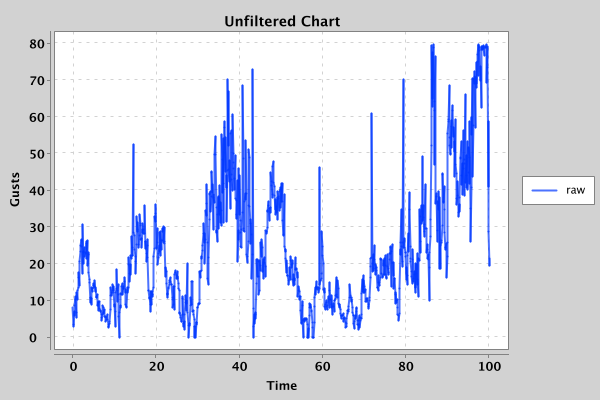

In [12]:
XYChart chart = QuickChart.getChart(
    "Unfiltered Chart", // Chart title
    "Time",             // x axis label
    "Gusts",            // y axis label
    "raw",              // Legend
    xData,              // x axis data 
    yData);             // y axis data
// Render the chart
BitmapEncoder.getBufferedImage(chart);

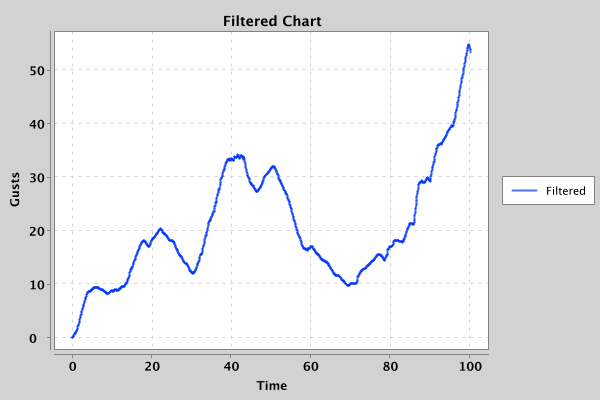

In [13]:
XYChart filteredChart = QuickChart.getChart(
    "Filtered Chart", // Chart title
    "Time",           // x axis label
    "Gusts",          // y axis label
    "Filtered",       // legend
    xData,            // x axis data - same as above
    filteredYData);   // y axis data - filtered this time
// Render the filtered chart
BitmapEncoder.getBufferedImage(filteredChart);